## RNN Regressor

https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/403_RNN_regressor.py

This tutorial shows intuitive regressor example that trains a RNN to predict/construct cos(t) from corresponding sin(t).

- Training is not batched, one sample for one epoch.
- Data is generated along with time.

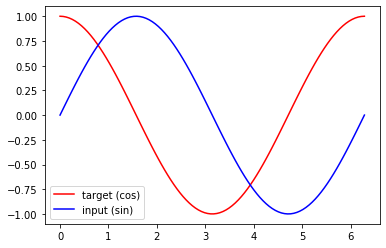

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


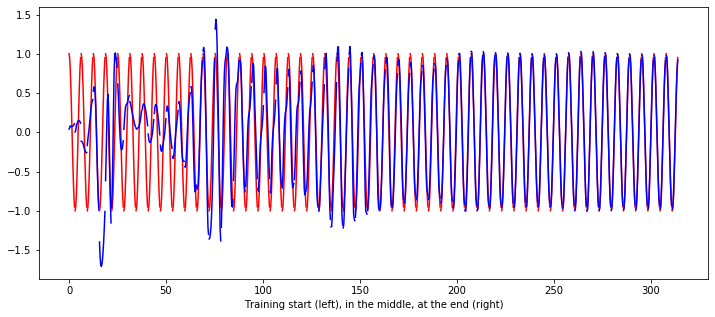

In [3]:
from dlcliche.notebook import *


"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
matplotlib
numpy
"""
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size
LR = 0.02           # learning rate

# show data
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)  # float32 for converting torch FloatTensor
x_np = np.sin(steps)
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()


class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)

        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

        # instead, for simplicity, you can replace above codes by follows
        # r_out = r_out.view(-1, 32)
        # outs = self.out(r_out)
        # outs = outs.view(-1, TIME_STEP, 1)
        # return outs, h_state
        
        # or even simpler, since nn.Linear can accept inputs of any dimension 
        # and returns outputs with same dimension except for the last
        # outs = self.out(r_out)
        # return outs

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()

h_state = None      # for initial hidden state

plt.figure(1, figsize=(12, 5))
plt.ion()           # continuously plot

for step in range(100):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32, endpoint=False)  # float32 for converting torch FloatTensor
    x_np = np.sin(steps)
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])    # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])

    prediction, h_state = rnn(x, h_state)   # rnn output
    # !! next step is important !!
    h_state = h_state.data        # repack the hidden state, break the connection from last iteration

    loss = loss_func(prediction, y)         # calculate loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    # plt.show() one by one

plt.xlabel('Training start (left), in the middle, at the end (right)')
plt.show()

## RNN Basic Check

Parameters and their shapes.

In [5]:
def show_model_prm(model):
    for param_name, param in model.named_parameters():
        print(param_name, param)

model = nn.RNN(input_size=3, hidden_size=4)
show_model_prm(model)

weight_ih_l0 Parameter containing:
tensor([[ 0.4624, -0.3329,  0.2833],
        [-0.3583,  0.3796,  0.2138],
        [-0.3460,  0.2337,  0.2136],
        [ 0.0960, -0.4094,  0.4267]], requires_grad=True)
weight_hh_l0 Parameter containing:
tensor([[-0.4002,  0.2806, -0.2807,  0.1519],
        [-0.3314, -0.0530, -0.1480,  0.2707],
        [-0.4444,  0.1502,  0.0789, -0.4046],
        [ 0.2727,  0.3182, -0.4768,  0.0238]], requires_grad=True)
bias_ih_l0 Parameter containing:
tensor([ 0.2418, -0.1595, -0.2779,  0.0717], requires_grad=True)
bias_hh_l0 Parameter containing:
tensor([ 0.2375,  0.3781, -0.3250, -0.4542], requires_grad=True)


In [6]:
model = nn.RNN(input_size=3, hidden_size=4, num_layers=2)
show_model_prm(model)

weight_ih_l0 Parameter containing:
tensor([[ 0.1460, -0.3781, -0.3255],
        [ 0.3315,  0.3991, -0.4130],
        [-0.0307, -0.3806, -0.1588],
        [-0.0396, -0.4015,  0.0613]], requires_grad=True)
weight_hh_l0 Parameter containing:
tensor([[ 0.2282,  0.4432,  0.4271,  0.2489],
        [-0.3829,  0.2218,  0.3174,  0.2604],
        [ 0.2266, -0.3459,  0.0899, -0.3259],
        [-0.2844, -0.0098,  0.0950,  0.3241]], requires_grad=True)
bias_ih_l0 Parameter containing:
tensor([ 0.1440,  0.3378,  0.4281, -0.0152], requires_grad=True)
bias_hh_l0 Parameter containing:
tensor([ 0.1343,  0.2712, -0.3597, -0.3516], requires_grad=True)
weight_ih_l1 Parameter containing:
tensor([[ 0.0495, -0.2467, -0.3147,  0.3411],
        [ 0.3977,  0.2095,  0.0898,  0.0959],
        [-0.3806,  0.1027, -0.0961,  0.1780],
        [ 0.3891,  0.2684,  0.0157, -0.2802]], requires_grad=True)
weight_hh_l1 Parameter containing:
tensor([[ 0.4002, -0.4131,  0.1115,  0.3522],
        [-0.0223,  0.4307,  0.0388,  0.

In [25]:
rnn(torch.Tensor([[[1]]]), torch.Tensor(np.zeros((1,1,32))))

(tensor([[[0.5336]]], grad_fn=<StackBackward>),
 tensor([[[ 0.1078,  0.4487, -0.4304,  0.4335, -0.6780,  0.0600, -0.0768,
            0.1882,  0.4125,  0.2761, -0.1350,  0.1495, -0.3579, -0.3580,
           -0.2033, -0.1019, -0.4300, -0.4167,  0.3159, -0.1589,  0.3203,
           -0.3743, -0.0627,  0.1992, -0.0822, -0.2364,  0.7061,  0.1598,
           -0.5692, -0.1374,  0.1608,  0.3859]]], grad_fn=<StackBackward>))

## RNN Behavior Check, One Sample or Multiple Time-Series?

It is confirmed that:
- Feeding sequence of time-series samples once and;
- Feeding 1 sample for all time-series samples;
- Will make the same result.

### Repeated forward() with 1 samples

In [96]:
from dlcliche.utils import *

def tot(arr): return torch.Tensor(arr)
def tonp(arr): return arr.detach().numpy() if isinstance(arr, torch.Tensor) else arr
def print_result(in_, out_, h_):
    print('in', tonp(in_))
    print('out', tonp(out_))
    print('h', tonp(h_))

time_series = np.array([1., 2., 3.])

deterministic_everything(1, pytorch=True)
rn = nn.RNN(1,1, batch_first=True)
rn.eval()

in_ = tot(time_series[np.newaxis, :, np.newaxis])
out_, h_ = rn(in_)
print_result(in_, out_, h_)

in [[[1.]
  [2.]
  [3.]]]
out [[[0.65884537]
  [0.7679181 ]
  [0.9019082 ]]]
h [[[0.9019082]]]


In [94]:
deterministic_everything(1, pytorch=True)
rn = nn.RNN(1,1, batch_first=True)
rn.eval()

h_ = tot([[[0]]])
for i in range(len(time_series)):
    in_ = tot(time_series[np.newaxis, i:i+1, np.newaxis])
    out_, h_ = rn(in_, h_)
    print_result(in_, out_, h_)

in [[[1.]]]
out [[[0.65884537]]]
h [[[0.65884537]]]
in [[[2.]]]
out [[[0.7679181]]]
h [[[0.7679181]]]
in [[[3.]]]
out [[[0.9019082]]]
h [[[0.9019082]]]


In [68]:
for name, p in rn.named_parameters():
    print(name, p)

weight_ih_l0 Parameter containing:
tensor([[0.5153]], requires_grad=True)
weight_hh_l0 Parameter containing:
tensor([[-0.4414]], requires_grad=True)
bias_ih_l0 Parameter containing:
tensor([-0.1939], requires_grad=True)
bias_hh_l0 Parameter containing:
tensor([0.4694], requires_grad=True)


In [97]:
def one_rnn(in_, h_):
    wih = 0.5153
    whh = -0.4414
    bih = -0.1939
    bhh = 0.4694
    out_ = np.tanh(in_ * wih + bih + h_ * whh + bhh)
    h_ = out_
    return out_, h_

h_ = 0.
for i in range(3):
    in_ = time_series[i]
    out_, h_ = one_rnn(in_, h_)
    print_result(in_, out_, h_)

in 1.0
out 0.6588619953056942
h 0.6588619953056942
in 2.0
out 0.7679363657160249
h 0.7679363657160249
in 3.0
out 0.9019228043438989
h 0.9019228043438989
